## Accuracy helper function

In [1]:
import torch

class EasyAcc:
    def __init__(self):
        self.n = 0
        self.sum = 0
        self.sumsq = 0

    def __iadd__(self, other):
        self.n += 1
        self.sum += other
        self.sumsq += other*other
        return self

    def __isub__(self, other):
        self.n += 1
        self.sum -= other
        self.sumsq += other*other
        return self

    def mean(self):
        return self.sum / max(self.n, 1)

    def var(self):
        from math import sqrt
        return sqrt(self.sumsq / max(self.n, 1) - self.mean()**2)

    def semean(self):
        from math import sqrt
        return self.var() / sqrt(max(self.n, 1))

## Inverse kinematics

In [2]:
class IK(torch.nn.Module):
    def __init__(self, dim_x, dim_a, dim_y):
        super().__init__()
        self.bilinear = torch.nn.Bilinear(in1_features=dim_x*dim_a, in2_features=dim_y, out_features=1)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    # Xs --> [batch, dim_x] 
    # As --> [batch, num_a, dim_a] 
    # Ys --> [batch, dim_y]
    def prelogits(self, Xs, As, Ys):
        batch, numa, dima = As.shape
        _, dimx = Xs.shape
        
        xview = Xs.unsqueeze(1).unsqueeze(3)            # [ batch, 1, dim_x, 1 ]
        aview = As.unsqueeze(2)                         # [ batch, num_a, 1, dim_a ]
        xaouter = torch.matmul(xview, aview)            # [ batch, num_a, dim_x, dim_a ]
        yview = Ys.unsqueeze(1).expand(-1, numa, -1)    # [ batch, num_a, dim_y ]
        return self.bilinear(xaouter.reshape(-1, numa, dimx*dima), yview.contiguous()).reshape(-1, numa)
    
    def predictions(self, prelogits):
        return self.softmax(prelogits)

In [3]:
class BilinearPredictor(torch.nn.Module):
    def __init__(self, dim_x, dim_a):
        super().__init__()
        if dim_x * dim_a > 0:
            self.bilinear = torch.nn.Bilinear(in1_features=dim_x, in2_features=dim_a, out_features=1)
        else:
            self.bilinear = None
            self.b = torch.nn.Parameter(torch.zeros(1))
        self.sigmoid = torch.nn.Sigmoid()
        
    def prelogits(self, Xs, As):
        if self.bilinear is not None:
            return self.bilinear(Xs.contiguous(), As.contiguous()).squeeze(1)
        else:
            return self.b.expand(Xs.shape[0])
    
    def prediction(self, prelogits):
        return self.sigmoid(prelogits)

## Exploration policy

In [4]:
class Policy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def sample(self, Fs):
        raise NotImplementedError
        
    def update(self, dt):
        raise NotImplementedError
        
class EpsilonGreedy(Policy):
    def __init__(self, epsilon, epsilon_t0):
        super().__init__()
        self.epsilon = epsilon
        self.epsilon_t0 = epsilon_t0
        self.t = epsilon_t0
        
    def myeps(self):
        return self.epsilon * (self.epsilon_t0 / self.t)**(1/3)
        
    def sample(self, Fs, As):
        myeps = self.myeps()
        
        unif = torch.rand(size=(Fs.shape[0], 1))
        should_explore = (unif < myeps).long()
        
        explore = torch.randint(low=0, high=Fs.shape[1], size=(Fs.shape[0], 1))
        exploit = torch.max(Fs, dim=1, keepdim=True).indices
        aindex = exploit + should_explore * (explore - exploit)
        
        action = torch.gather(input=As, dim=1, index=aindex.unsqueeze(2).expand(-1, -1, As.shape[2])).squeeze(1)
        isgreedy = (aindex == exploit).long()
        paction = myeps * torch.ones(size=(Fs.shape[0],1))/Fs.shape[1] + isgreedy * (1 - myeps)
        
        return action, paction, aindex
    
    def update(self, dt):
        self.t += dt

## Set up simulator

In [5]:
class Simulator(torch.utils.data.Dataset):
    def __init__(self, *, T, nusers, nactions, pdislike, seed):
        import random

        assert nusers > 1
        assert nactions > 2
        
        super().__init__()

        self.random = random.Random(seed)
        self.nusers = nusers
        self.nactions = nactions
        self.actions = torch.eye(self.nactions)
        self.feedbacks = [ 'click', 'like', 'dislike', 'skip', 'none']
        self.pdislike = pdislike

        # User's ground truth preference
        # This is only used to evaluate IGL learning result
        # Never revealed to IGL algorithm
        self.enjoys = {}
        self.hates = {}
        
        for n in range(nusers):            
            enjoy_action, hate_action = self.random.sample(list(range(nactions)), 2)
            self.enjoys[n] = enjoy_action
            self.hates[n] = hate_action
        
        self.contexts = torch.Tensor([ self.random.randint(0, self.nusers-1) for _ in range(T) ]).long()
        self.random = random.Random(1664525*seed + 1013904223)

    def __len__(self):
        return len(self.contexts)
    
    def __getitem__(self, idx):
        context = torch.nn.functional.one_hot(self.contexts[idx], num_classes=self.nusers).float()
        return context, self.actions

    def first_nonzero(self, x, axis=0):
        nonz = (x != 0)
        return ((nonz.cumsum(axis) == 1) & nonz).max(axis, keepdim=True)
    
    def get_one_hot_id(self, onehot):
        return self.first_nonzero(onehot, axis=-1)[1].squeeze().item()
        
    def enjoys_the_action(self, Xs, As):
        user_id = self.get_one_hot_id(Xs)
        action_id = self.get_one_hot_id(As)
        return self.enjoys[user_id] == action_id
    
    def hates_the_action(self, Xs, As):
        user_id = self.get_one_hot_id(Xs)
        action_id = self.get_one_hot_id(As)
        return self.hates[user_id] == action_id

## 3 states simulator

In [6]:
class ThreeStatesSimulator(Simulator):
    def sample_feedback(self, Xs, As):
        results = []
        for context, chosen_action in zip(Xs, As):
            if self.enjoys_the_action(context, chosen_action):
                probs = [ 0.75, 0.25, 0, 0, 0 ]
            elif self.hates_the_action(context, chosen_action):
                probs = [ 0, 0, self.pdislike, 1 - self.pdislike, 0 ]
            else:
                probs = [ 0, 0, 0, 0, 1 ]
        
            feedback = self.random.choices(list(range(len(self.feedbacks))), weights=probs)[0]
            results.append(torch.nn.functional.one_hot(torch.LongTensor([feedback]), num_classes = len(self.feedbacks)).float())
        return torch.cat(results, dim=0)
    
    def is_definitely_negative(self, Xs, Ys):
        return self.first_nonzero(Ys, axis=-1)[1].squeeze(1) == 2
    
    def true_reward(self, Xs, As):
        return [ self.enjoys_the_action(x, a) - self.hates_the_action(x, a) for x, a in zip(Xs, As) ]

## 2 states simulator

In [7]:
class TwoStatesSimulator(Simulator):
    def sample_feedback(self, Xs, As):
        results = []
        for context, chosen_action in zip(Xs, As):
            if self.enjoys_the_action(context, chosen_action):
                probs = [ 0.75, 0.25, 0, 0, 0 ]
            else:
                probs = [ 0, 0, self.pdislike / 2.0, (1 - self.pdislike) / 2.0, 1 / 2.0 ]
        
            feedback = self.random.choices(list(range(len(self.feedbacks))), weights=probs)[0]
            results.append(torch.nn.functional.one_hot(torch.LongTensor([feedback]), num_classes = len(self.feedbacks)).float())
        return torch.cat(results, dim=0)
    
    def true_reward(self, Xs, As):
        return [self.enjoys_the_action(x, a) for x, a in zip(Xs, As)]


## Epsilon-Greedy

In [8]:
def run_sim(*, seed, T=150_000, n_states=2):
    from math import sqrt
    import itertools
    
    nusers = 5
    nactions = 11
    batch_size = 100
    pdislike = 0.1
    lr = 0.001
    epsilon = 1
    epsilon_t0 = 100
    
    # n_states - 1 -> the number of latent states we are certain with
    n_extreme_states = n_states - 1
    optimal_accuracy = ((nactions - n_extreme_states) / nactions) * (1 / (nactions - n_extreme_states)) + ((1/nactions) * 1) * n_extreme_states
    print(f'optimal action prediction accuracy = {optimal_accuracy : .4f}')

    positive_rewards_counter = []
    negative_rewards_counter = []
    neutral_rewards_counter = []
    
    if n_states == 2:
        sim = TwoStatesSimulator(T=T, nusers=nusers, nactions=nactions, pdislike=pdislike, seed=seed); seed += 1
    else:
        sim = ThreeStatesSimulator(T=T, nusers=nusers, nactions=nactions, pdislike=pdislike, seed=seed); seed += 1
        
    torch.manual_seed(seed); seed += 1
    loader = torch.utils.data.DataLoader(sim, batch_size=batch_size, shuffle=False)

    policy = EpsilonGreedy(epsilon, epsilon_t0)

    ik = IK(dim_x=nusers, dim_a=nactions, dim_y=len(sim.feedbacks))
    reward_predictor = BilinearPredictor(dim_x=nusers, dim_a=nactions)

    action_loss = torch.nn.CrossEntropyLoss(reduction='none')
    action_optimizer = torch.optim.Adam(ik.parameters(), lr=lr*sqrt(batch_size))
    regloss = torch.nn.MSELoss(reduction='none')
    regoptimizer = torch.optim.Adam(reward_predictor.parameters(), lr=lr*sqrt(batch_size))

    print('{:<5s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s}'.format(
        'bno',  'loss', 'since', 'acc', 'since', 'pol', 'since', 'greedy', 'since', 'eps'), flush=True) 
    avloss, avacc, avpol, avgreedy = [ EasyAcc() for _ in range(4) ]
    avlosssincelast, avaccsincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(4) ]
    
    for bno, minibatch in enumerate(loader):
        Xs, As = minibatch

        with torch.no_grad():
            rhat = reward_predictor.prelogits(Xs.unsqueeze(1).expand(-1, As.shape[1], -1), As).squeeze(2)
            action, paction, aindex = policy.sample(rhat, As)
            
            true_reward = torch.Tensor(sim.true_reward(Xs, action))
            avpol += torch.mean(true_reward).item()
            avpolsincelast += torch.mean(true_reward).item()
            
            greedy = torch.max(rhat, dim=1, keepdim=True).indices
            greedyaction = torch.gather(input=As, dim=1, index=greedy.unsqueeze(2).expand(-1, -1, As.shape[2])).squeeze(1)
            greedyrewards = torch.Tensor(sim.true_reward(Xs, greedyaction))
            avgreedy += torch.mean(greedyrewards).item()
            avgreedysincelast += torch.mean(greedyrewards).item()
            Ys = sim.sample_feedback(Xs, action)

        action_optimizer.zero_grad()
        prepapred = ik.prelogits(Xs, As, Ys)
        
        rawactionloss = action_loss(prepapred, aindex.squeeze(1)).unsqueeze(1)
        actioniw = 1/(As.shape[1]*paction)
        batchactionloss = torch.sum(torch.mul(actioniw, rawactionloss)) / torch.sum(actioniw)
        batchactionloss.backward()
        action_optimizer.step()
                
        with torch.no_grad():
            papred = torch.gather(input=ik.predictions(prepapred), index=aindex, dim=1).squeeze()
            is_extreme = papred > (2 / As.shape[1])
            
        if torch.any(is_extreme):
            with torch.no_grad():
                fake_reward = torch.zeros(Xs.shape[0])
                fake_reward[is_extreme] = 1
                
                states, counts = true_reward.unique(return_counts=True)
                
                if -1 not in states:
                    negative_rewards_counter.append(0)
                
                if 1 not in states:
                    positive_rewards_counter.append(0)
    
                for latent_reward, count in zip(states, counts):
                    if latent_reward.item() == -1:
                        negative_rewards_counter.append(count.item())
                    elif latent_reward.item() == 1:
                        positive_rewards_counter.append(count.item())
                    else:
                        neutral_rewards_counter.append(count.item())
            
            regoptimizer.zero_grad()
            rewardpred = reward_predictor.prelogits(Xs, action)
            batchregloss = torch.sum(torch.mul(actioniw, regloss(rewardpred, fake_reward).unsqueeze(1))) / torch.sum(actioniw)
            batchregloss.backward()
            regoptimizer.step()
            
            with torch.no_grad():
                policy.update(Xs.shape[0])

        with torch.no_grad():
            avloss += batchactionloss.item()
            avlosssincelast += batchactionloss.item()
                
            a_max_pred = torch.max(prepapred, dim=1, keepdim=True)
            avacc += torch.mean(torch.mul(actioniw, (aindex == a_max_pred.indices).float())).item()
            avaccsincelast += torch.mean(torch.mul(actioniw, (aindex == a_max_pred.indices).float())).item()

            if bno & (bno - 1) == 0:
                print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
                    bno,  
                    avloss.mean(), avlosssincelast.mean(),
                    avacc.mean(), avaccsincelast.mean(),
                    avpol.mean(), avpolsincelast.mean(),
                    avgreedy.mean(), avgreedysincelast.mean(),
                    policy.myeps(),
                ), flush=True)
                avlosssincelast, avaccsincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(4) ]
    print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
        bno,  
        avloss.mean(), avlosssincelast.mean(),
        avacc.mean(), avaccsincelast.mean(),
        avpol.mean(), avpolsincelast.mean(),
        avgreedy.mean(), avgreedysincelast.mean(),
        policy.myeps()
    ), flush=True)
    return positive_rewards_counter, neutral_rewards_counter, negative_rewards_counter


## Plot helper function

In [9]:
def plot_result(positive_rewards, neutral_rewards, negative_rewards=None, n_states=2):
    from matplotlib import pyplot as plt
    from matplotlib import rc
    import pandas as pd

    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    
    legend_font_size = 14
    tick_font_size = 14
    label_font_size = 16
    xlim = 1450
    ylim = 1

    positive_reward_color = (120/255, 94/255, 240/255) # these are the color themes we will use for each state across all plots
    neutral_reward_color = (255/255, 176/255, 0/255)
    negative_reward_color = (220/255, 38/255, 127/255)

    fig, axes = plt.subplots()
    plt.plot(pd.Series([i/100 for i in positive_rewards]).rolling(5).mean(),color=positive_reward_color,label='$r=1$')
    plt.plot(pd.Series([i/100 for i in neutral_rewards]).rolling(5).mean(),color=neutral_reward_color,label='$r=0$')
    
    if negative_rewards is not None:
        plt.plot(pd.Series([i/100 for i in negative_rewards]).rolling(5).mean(),color=negative_reward_color,label='$r=-1$')
        
    if n_states == 2:
        plt.legend(bbox_to_anchor=(0.2,1.02,0.6,0.2), loc="lower left", mode="expand", ncol=2, fontsize=legend_font_size)
    else:
        plt.legend(bbox_to_anchor=(0.05,1.02,0.9,0.2), loc="lower left", mode="expand", ncol=3, fontsize=legend_font_size)
        
    plt.xlabel('number of iterations', fontsize=label_font_size)
    plt.ylabel('fraction of rounds', fontsize=label_font_size)
    plt.xticks(fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)
    plt.xlim(0, xlim)    
    plt.ylim(0, ylim)


# Run simulation

## 2 latent states

optimal action prediction accuracy =  0.1818
bno  	loss     since   	acc      since   	pol      since   	greedy   since   	eps     
0    	2.39507  2.39507 	0.11000  0.11000 	0.06000  0.06000 	0.00000  0.00000 	1.00000 
1    	2.40000  2.40492 	0.09500  0.08000 	0.06500  0.07000 	0.00000  0.00000 	1.00000 
2    	2.39991  2.39973 	0.09000  0.08000 	0.07000  0.08000 	0.00000  0.00000 	1.00000 
4    	2.39729  2.39336 	0.11000  0.14000 	0.07600  0.08500 	0.00000  0.00000 	1.00000 
8    	2.39108  2.38332 	0.11556  0.12250 	0.08889  0.10500 	0.00000  0.00000 	1.00000 
16   	2.38055  2.36871 	0.13941  0.16625 	0.09588  0.10375 	0.00000  0.00000 	1.00000 
32   	2.36492  2.34831 	0.16212  0.18625 	0.09576  0.09563 	0.00000  0.00000 	1.00000 
64   	2.33840  2.31106 	0.16861  0.17530 	0.11031  0.12531 	0.05477  0.11125 	0.34668 
128  	2.29114  2.24313 	0.17198  0.17541 	0.38434  0.66266 	0.45519  0.86187 	0.22482 
256  	2.23589  2.18021 	0.17633  0.18071 	0.60265  0.82266 	0.72654  1.00000 	0.16667

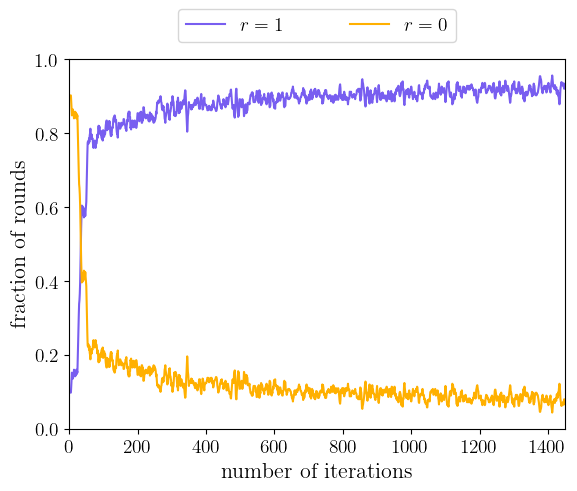

In [10]:
def run_2_states(*, seed):
    positive_rewards, neutral_rewards, _ = run_sim(seed=seed)
    plot_result(positive_rewards, neutral_rewards)

run_2_states(seed=2)

## 3 latent states

optimal action prediction accuracy =  0.2727
bno  	loss     since   	acc      since   	pol      since   	greedy   since   	eps     
0    	2.40328  2.40328 	0.09000  0.09000 	-0.04000 -0.04000	0.00000  0.00000 	1.00000 
1    	2.40256  2.40184 	0.07500  0.06000 	-0.03000 -0.02000	0.00000  0.00000 	1.00000 
2    	2.39806  2.38906 	0.07333  0.07000 	-0.03000 -0.03000	0.00000  0.00000 	1.00000 
4    	2.39258  2.38435 	0.08600  0.10500 	-0.04000 -0.05500	0.00000  0.00000 	1.00000 
8    	2.38360  2.37237 	0.12444  0.17250 	-0.00444 0.04000 	0.00000  0.00000 	1.00000 
16   	2.36658  2.34744 	0.17941  0.24125 	0.01000  0.02625 	0.00000  0.00000 	1.00000 
32   	2.33454  2.30049 	0.22242  0.26813 	0.00576  0.00125 	0.00000  0.00000 	1.00000 
64   	2.28162  2.22706 	0.23908  0.25625 	0.03662  0.06844 	0.05477  0.11125 	0.34668 
128  	2.19581  2.10866 	0.24922  0.25952 	0.21023  0.38656 	0.28605  0.52094 	0.22482 
256  	2.08719  1.97771 	0.25514  0.26110 	0.33852  0.46781 	0.43969  0.59453 	0.16667

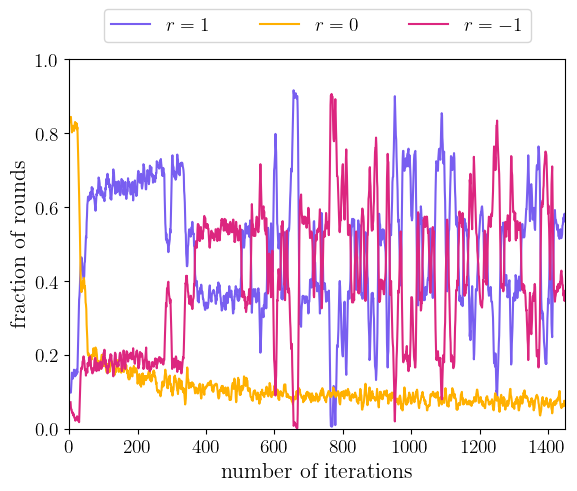

In [11]:
def run_3_states(*, seed):
    positive_rewards, neutral_rewards, negative_rewards = run_sim(seed=seed, n_states=3)
    plot_result(positive_rewards, neutral_rewards, negative_rewards, 3)

run_3_states(seed=2)